In [33]:
import sys
sys.path.append('C:\Users\micmitch\Documents\UBC\GIF\Programs\SimPEG')
import SimPEG as simpeg
import simpegDCIP as DC

import numpy as np
import numpy.matlib
import scipy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# import itertools
import time

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [34]:


# Minimum cell size in each direction
dx = 1.
dy = 1.
dz = 1.

# Number of core cells in each direction
nCoreX = 71.
nCoreY = 83.
nCoreZ = 51.

nPadX = 14
nPadY = 14
nPadZ = 14


# Cell widths
# hx = [(dx,nCoreX)]
# hy = [(dy,nCoreY)]
# hz = [(dz,nCoreZ)]
hx = [(dx,nPadX, -1.3),(dx,nCoreX),(dx,nPadX, 1.3)]
hy = [(dy,nPadY, -1.3),(dy,nCoreY),(dy,nPadY, 1.3)]
hz = [(dz,nPadZ, -1.3),(dz,nCoreZ),(dz,nPadZ, 1.3)]

# Calculate X padding distance
hPadX = np.zeros([nPadX+1,1])
hPadX[0] = dx
for i in range (1,nPadX+1):
    hPadX[i] = hPadX[i-1]*1.3

xPadDist = np.max(np.cumsum(hPadX[1:nPadX+1]))

# Calculate Y padding distance
hPadY = np.zeros([nPadY+1,1])
hPadY[0] = dy
for i in range (1,nPadY+1):
    hPadY[i] = hPadY[i-1]*1.3

yPadDist = np.max(np.cumsum(hPadY[1:nPadY+1]))

# Calculate Z padding distance
hPadZ = np.zeros([nPadZ+1,1])
hPadZ[0] = dz
for i in range (1,nPadZ+1):
    hPadZ[i] = hPadZ[i-1]*1.3

zPadDist = np.max(np.cumsum(hPadZ[1:nPadZ+1]))

# Desired Core mesh origin (Bottom SW corner)
x0_core = -10.
y0_core = -22.
z0_core = 0.

# Mesh origin (Bottom SW corner)
x0 = x0_core - xPadDist
y0 = y0_core - yPadDist
z0 = z0_core - zPadDist


In [35]:
mesh = simpeg.Mesh.TensorMesh([hx, hy, hz],[x0,y0,z0])
print mesh

  ---- 3-D TensorMesh ----  
   x0: -176.29
   y0: -188.29
   z0: -166.29
  nCx: 99
  nCy: 111
  nCz: 79
   hx: 39.37, 30.29, 23.30, 17.92, 13.79, 10.60, 8.16, 6.27, 4.83, 3.71, 2.86, 2.20, 1.69, 1.30, 71*1.00, 1.30, 1.69, 2.20, 2.86, 3.71, 4.83, 6.27, 8.16, 10.60, 13.79, 17.92, 23.30, 30.29, 39.37
   hy: 39.37, 30.29, 23.30, 17.92, 13.79, 10.60, 8.16, 6.27, 4.83, 3.71, 2.86, 2.20, 1.69, 1.30, 83*1.00, 1.30, 1.69, 2.20, 2.86, 3.71, 4.83, 6.27, 8.16, 10.60, 13.79, 17.92, 23.30, 30.29, 39.37
   hz: 39.37, 30.29, 23.30, 17.92, 13.79, 10.60, 8.16, 6.27, 4.83, 3.71, 2.86, 2.20, 1.69, 1.30, 51*1.00, 1.30, 1.69, 2.20, 2.86, 3.71, 4.83, 6.27, 8.16, 10.60, 13.79, 17.92, 23.30, 30.29, 39.37


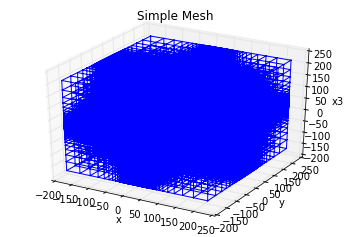

In [36]:
mesh.plotGrid()
plt.title('Simple Mesh')
plt.xlabel('x')
plt.ylabel('y')
# ax.set_zlabel('z')

In [37]:
# Create synthetic model
sigmaFull = 1e-4
sigma = np.ones(mesh.nC)*sigmaFull

# Add tunnels
sigmaTunnel = 1e-8

t1_1 = np.array([2,49,24])
t1_2 = np.array([5,15,27])
tunnel1 = simpeg.Utils.ModelBuilder.getIndicesBlock(t1_1,t1_2, mesh.gridCC)
sigma[tunnel1] = sigmaTunnel

t2_1 = [2,49,24];
t2_2 = [49,46,27];
tunnel2 = simpeg.Utils.ModelBuilder.getIndicesBlock(t2_1,t2_2, mesh.gridCC)
sigma[tunnel2] = sigmaTunnel

t3_1 = [46,49,24];
t3_2 = [49,-10,27];
tunnel3 = simpeg.Utils.ModelBuilder.getIndicesBlock(t3_1,t3_2, mesh.gridCC)
sigma[tunnel3] = sigmaTunnel

# Add conductive block
sigmaBlk1 = 10;
b1_1 = [20,30,16];
b1_2 = [30,20,35];
blk1 = simpeg.Utils.ModelBuilder.getIndicesBlock(b1_1,b1_2, mesh.gridCC)
sigma[blk1] = sigmaBlk1

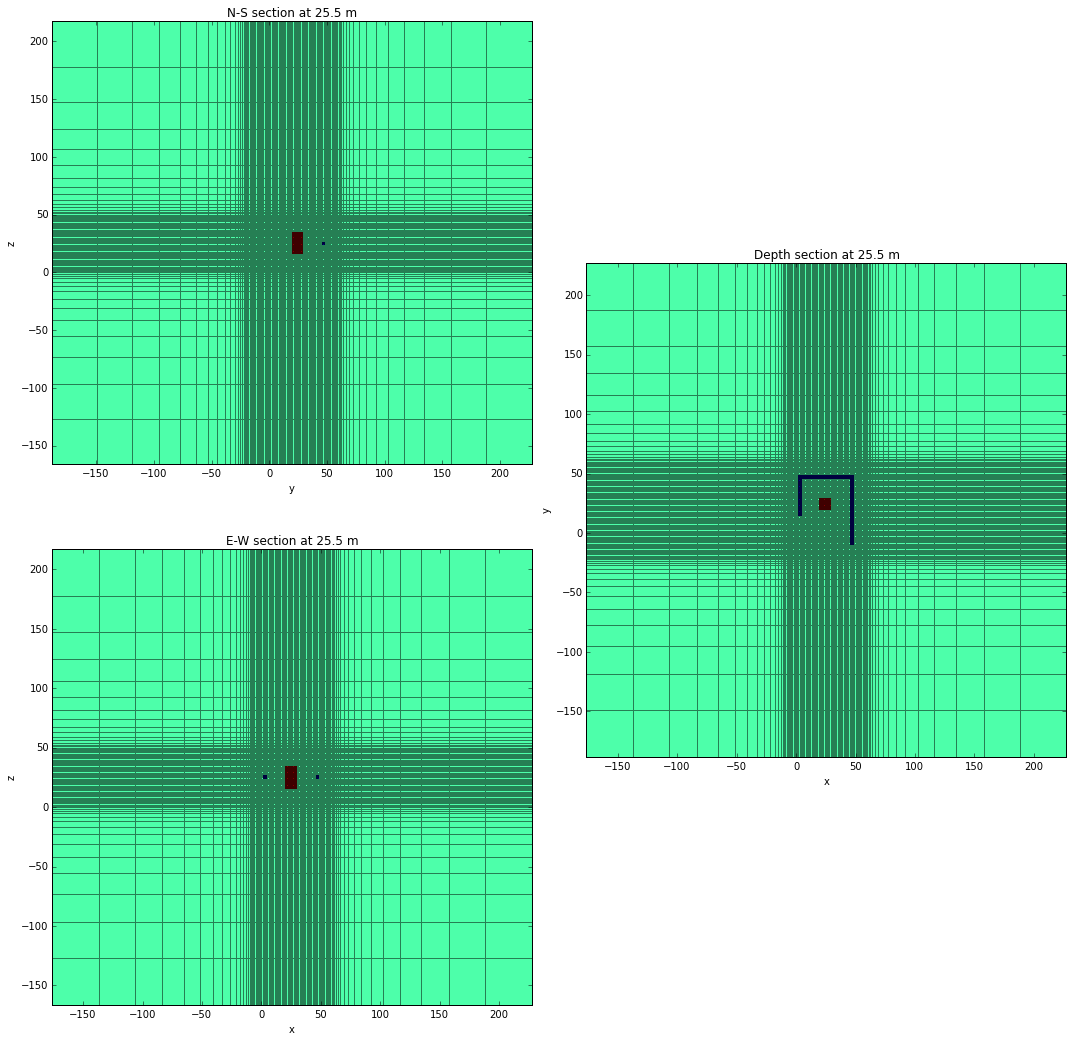

In [38]:
xSliceInd = 49
ySliceInd = 61
zSliceInd = 39
# xSliceInd = int(mesh.nCx/2)
# print xSliceInd
# ySliceInd = int(mesh.nCy/2)
# print ySliceInd
# zSliceInd = int(mesh.nCz/2)
# print zSliceInd


gs = gridspec.GridSpec(4, 4)

fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
ax1 = plt.subplot(gs[0:2, 0:2])
# ax = plt.subplot(3,1,1, aspect='equal')
mesh.plotSlice(np.log10(sigma), ax =ax1, normal='X', ind=xSliceInd, grid=True)
ax1.set_title('N-S section at '+str(mesh.vectorCCx[xSliceInd])+' m')
plt.gca().set_aspect('equal', adjustable='box')

ax2 = plt.subplot(gs[2:4, 0:2])
# ax = plt.subplot(3,1,2, aspect='equal')
mesh.plotSlice(np.log10(sigma), ax =ax2, normal='Y', ind=ySliceInd, grid=True)
ax2.set_title('E-W section at '+str(mesh.vectorCCy[ySliceInd])+' m')
plt.gca().set_aspect('equal', adjustable='box')

ax3 = plt.subplot(gs[0:4, 2:4])
# ax = plt.subplot(3,1,3, aspect='equal')
mesh.plotSlice(np.log10(sigma), ax =ax3, normal='Z', ind=zSliceInd, grid=True)
ax3.set_title('Depth section at '+str(mesh.vectorCCz[zSliceInd])+' m')
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()


In [39]:
# Define electrode locations
# elecLoc = np.array([[5.5, 15.5, 25.5], 
#     [ 5.5, 20.5, 25.5 ],
#     [ 5.5, 25.5, 25.5 ],
#     [ 5.5, 30.5, 25.5 ],
#     [ 5.5, 35.5, 25.5 ],
#     [ 5.5, 40.5, 25.5 ],
#     [ 5.5, 45.5, 25.5 ],
#     [ 10.5, 45.5, 25.5 ],
#     [ 15.5, 45.5, 25.5 ],
#     [ 20.5, 45.5, 25.5 ],
#     [ 25.5, 45.5, 25.5 ],
#     [ 30.5, 45.5, 25.5 ],
#     [ 35.5, 45.5, 25.5 ],
#     [ 40.5, 45.5, 25.5 ],
#     [ 45.5, 45.5, 25.5 ],
#     [ 45.5, 40.5, 25.5 ],
#     [ 45.5, 35.5, 25.5 ],
#     [ 45.5, 30.5, 25.5 ],
#     [ 45.5, 25.5, 25.5 ],
#     [ 45.5, 20.5, 25.5 ],
#     [ 45.5, 15.5, 25.5 ],
#     [ 45.5, 10.5, 25.5 ],
#     [ 45.5,  5.5, 25.5 ],
#     [ 45.5,  0.5, 25.5 ],
#     [ 45.5, -4.5, 25.5 ],
#     [ 45.5, -9.5, 25.5 ]])

# Dipole-Pole survey with a Single Tx dipole and Rx electrodes at every cell center  

def ismember_rows(b, a):
    nRows = b.shape[0]
    isMemberVec = np.zeros(nRows)
    for i in range(0, nRows):
#         if (np.array_equal(b[i,:], a)):
            isMemberVec[i] = 1
    return isMemberVec


# Test function
# b =np.array([[5.5, 15.5, 25.5], 
#     [ 5.5, 20.5, 25.5 ],
#     [ 5.5, 25.5, 25.5 ],
#     [ 5.5, 30.5, 25.5 ],
#     [ 5.5, 35.5, 25.5 ],
#     [ 5.5, 40.5, 25.5 ],
#     [ 5.5, 45.5, 25.5 ],
#     [ 10.5, 45.5, 25.5 ],
#     [ 15.5, 45.5, 25.5 ],
#     [ 20.5, 45.5, 25.5 ],
#     [ 25.5, 45.5, 25.5 ],
#     [ 30.5, 45.5, 25.5 ],
#     [ 35.5, 45.5, 25.5 ],
#     [ 40.5, 45.5, 25.5 ],
#     [ 45.5, 45.5, 25.5 ],
#     [ 45.5, 40.5, 25.5 ],
#     [ 5.5, 25.5, 25.5 ],
#     [ 45.5, 35.5, 25.5 ],
#     [ 45.5, 30.5, 25.5 ],
#     [ 45.5, 25.5, 25.5 ],
#     [ 45.5, 20.5, 25.5 ],
#     [ 45.5, 15.5, 25.5 ],
#     [ 45.5, 10.5, 25.5 ],
#     [ 5.5, 25.5, 25.5 ],
#     [ 45.5,  5.5, 25.5 ],
#     [ 45.5,  0.5, 25.5 ],
#     [ 45.5, -4.5, 25.5 ],
#     [ 45.5, -9.5, 25.5 ]])
# a = np.array([ 5.5, 25.5, 25.5 ])
# isMemberVec = ismember_rows(b,a)
# print isMemberVec
# print isMemberVec.shape

# isMemberInd = np.array(np.where(isMemberVec  == 1)).flatten()
# print isMemberInd
# print isMemberInd.shape

CCLocs = mesh.gridCC
ALoc_Ind = simpeg.Utils.meshutils.closestPoints(mesh, [ 5.5, 25.5, 25.5 ], gridLoc='CC')
ALoc = CCLocs[ALoc_Ind]
BLoc_Ind = simpeg.Utils.meshutils.closestPoints(mesh, [ 45.5, 25.5, 25.5 ], gridLoc='CC')
BLoc = CCLocs[BLoc_Ind]
MLoc = CCLocs
NLoc = CCLocs[simpeg.Utils.meshutils.closestPoints(mesh, [ -120, 25.5, 25.5 ], gridLoc='CC')]
NLoc = numpy.matlib.repmat(NLoc, MLoc.shape[0], 1)
# print NLoc[1:5,:]
# print NLoc.shape

In [40]:
# Create Tx and Rx data objects for the survey object

RxData = DC.RxDipole(MLoc, NLoc)
TxData = DC.SrcDipole([RxData], [ALoc],[BLoc])

In [41]:
# Assign TxData to DC survey object
survey = DC.SurveyDC([TxData])
# Assign mesh to probelm object
problem = DC.ProblemDC_CC(mesh)
# Pair survey with problem
problem.pair(survey)

In [42]:
# try:
#     from pymatsolver import MumpsSolver
#     problem.Solver = MumpsSolver
# except Exception, e:
#     problem.Solver = SolverLU



In [43]:
#Set boundary conditions
mesh.setCellGradBC('neumann')

# Define the differential operators needed for the DC problem
Div = mesh.faceDiv
Grad = mesh.cellGrad
Msig = simpeg.Utils.sdiag(1./(mesh.aveF2CC.T*(1./sigma)))

A = Div*Msig*Grad

# Change one corner to deal with nullspace
A[0,0] = 1
A = simpeg.sp.csc_matrix(A)

# Source vector
q = np.zeros(mesh.nC)
q[ALoc_Ind] = 1 / mesh.vol[ALoc_Ind]
q[BLoc_Ind] = -1 / mesh.vol[BLoc_Ind]



# Solve the system iteratively, as Dom did in SimPEG Tutorial - DC Fwr Problem.
# Create a simple Jacobi preconditioner (inverse of the main diagonal)
dA = A.diagonal()
P = simpeg.sp.spdiags(1/dA,0,A.shape[0],A.shape[0])

# Solve forward problem
start_time = time.time() # Start timer

# Ainv = problem.Solver(A) # Freezes computer
# phi = Ainv*q # Solve for the potentials everywhere

# Iterative Solve
Ainvb = simpeg.sp.linalg.bicgstab(P*A,P*q, tol=1e-5)

# We now have the potential everywhere
phi = simpeg.mkvc(Ainvb[0])

print 'Solve Time:{0} sec'.format(time.time()- start_time)

Solve Time:13.5450000763 sec


(-50, 100)

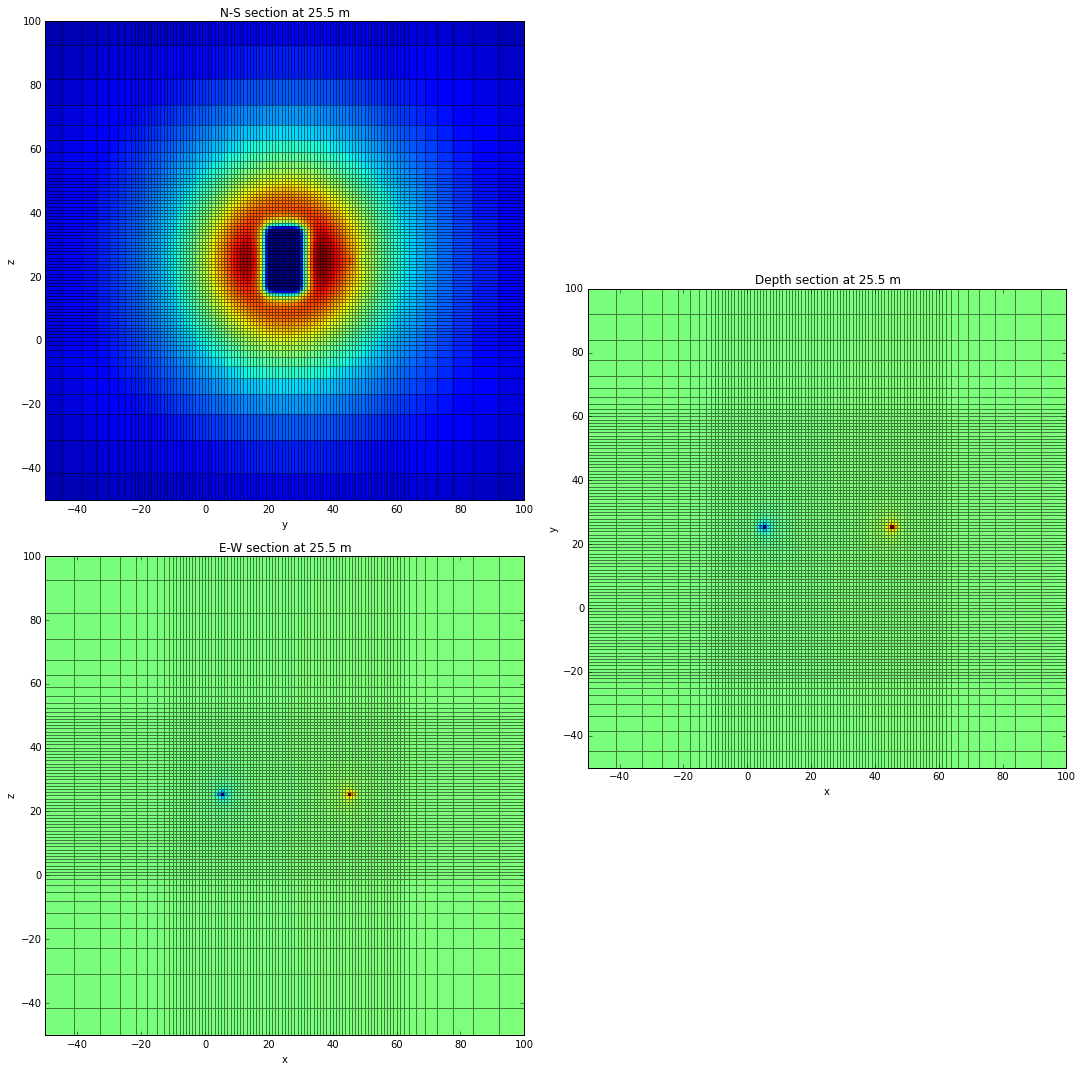

In [44]:
xSliceInd = 49
ySliceInd = 61
zSliceInd = 39
# xSliceInd = int(mesh.nCx/2)
# print xSliceInd
# ySliceInd = int(mesh.nCy/2)
# print ySliceInd
# zSliceInd = int(mesh.nCz/2)
# print zSliceInd


gs = gridspec.GridSpec(4, 4)

fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
ax1 = plt.subplot(gs[0:2, 0:2])
# ax = plt.subplot(3,1,1, aspect='equal')
mesh.plotSlice(phi, ax =ax1, normal='X', ind=xSliceInd, grid=True)
ax1.set_title('N-S section at '+str(mesh.vectorCCx[xSliceInd])+' m')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-50, 100])
plt.ylim([-50, 100])

ax2 = plt.subplot(gs[2:4, 0:2])
# ax = plt.subplot(3,1,2, aspect='equal')
mesh.plotSlice(phi, ax =ax2, normal='Y', ind=ySliceInd, grid=True)
ax2.set_title('E-W section at '+str(mesh.vectorCCy[ySliceInd])+' m')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-50, 100])
plt.ylim([-50, 100])

ax3 = plt.subplot(gs[0:4, 2:4])
# ax = plt.subplot(3,1,3, aspect='equal')
mesh.plotSlice(phi, ax =ax3, normal='Z', ind=zSliceInd, grid=True)
ax3.set_title('Depth section at '+str(mesh.vectorCCz[zSliceInd])+' m')
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.xlim([-50, 100])
plt.ylim([-50, 100])

In [45]:
j = Msig*Grad*phi

(-50, 100)

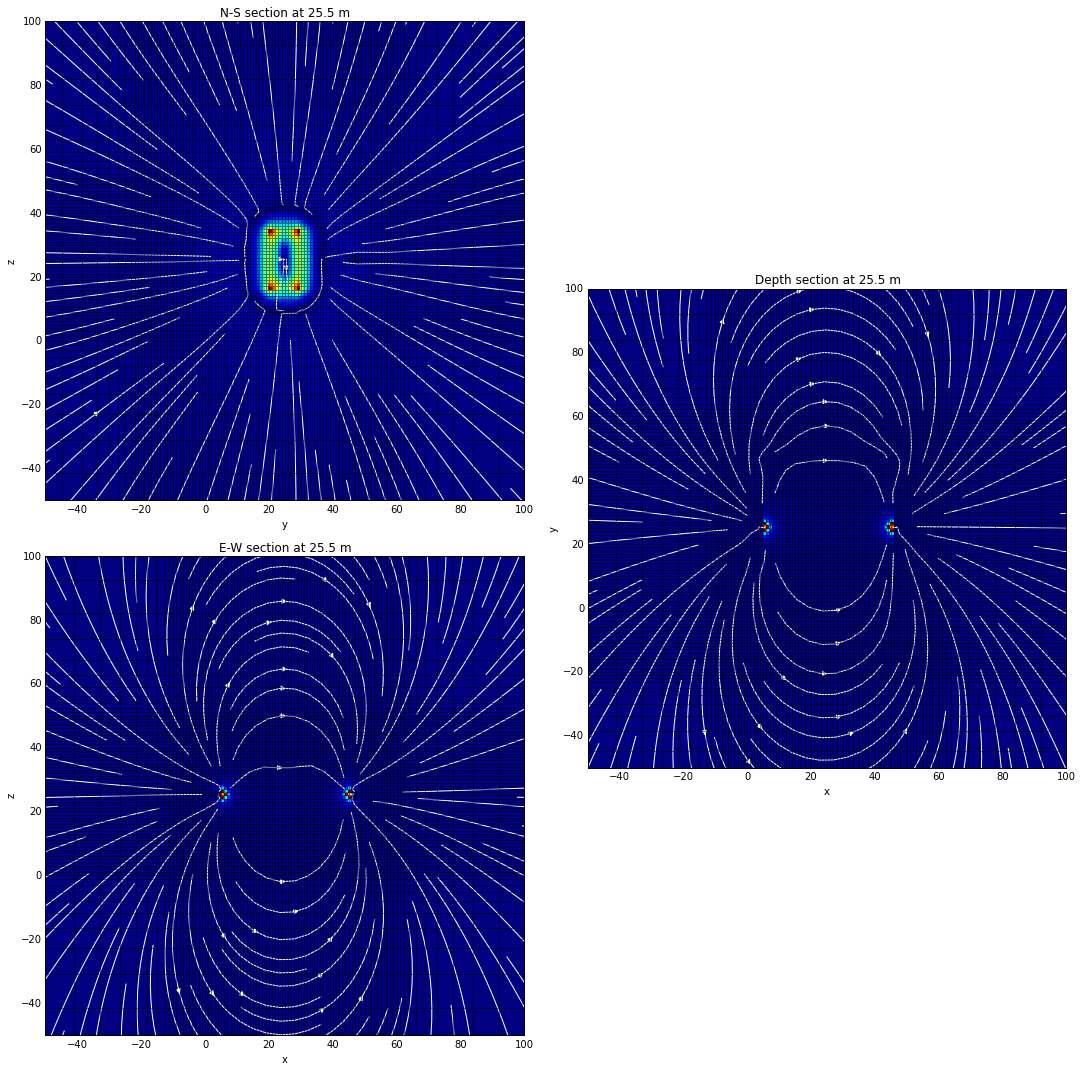

In [46]:
xSliceInd = 49
ySliceInd = 61
zSliceInd = 39
# xSliceInd = int(mesh.nCx/2)
# print xSliceInd
# ySliceInd = int(mesh.nCy/2)
# print ySliceInd
# zSliceInd = int(mesh.nCz/2)
# print zSliceInd


gs = gridspec.GridSpec(4, 4)

fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
ax1 = plt.subplot(gs[0:2, 0:2])
# ax = plt.subplot(3,1,1, aspect='equal')
mesh.plotSlice(mesh.aveF2CCV*j, ax =ax1, normal='X', vType='CCv', ind=xSliceInd, grid=True, view='vec', streamOpts={"density":3, "color":'w'})
ax1.set_title('N-S section at '+str(mesh.vectorCCx[xSliceInd])+' m')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-50, 100])
plt.ylim([-50, 100])

ax2 = plt.subplot(gs[2:4, 0:2])
# ax = plt.subplot(3,1,2, aspect='equal')
mesh.plotSlice(mesh.aveF2CCV*j, ax =ax2, normal='Y', vType='CCv', ind=ySliceInd, grid=True, view='vec', streamOpts={"density":3, "color":'w'})
ax2.set_title('E-W section at '+str(mesh.vectorCCy[ySliceInd])+' m')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-50, 100])
plt.ylim([-50, 100])

ax3 = plt.subplot(gs[0:4, 2:4])
# ax = plt.subplot(3,1,3, aspect='equal')
mesh.plotSlice(mesh.aveF2CCV*j, ax =ax3, normal='Z', vType='CCv', ind=zSliceInd, grid=True,view='vec', streamOpts={"density":3, "color":'w'})
ax3.set_title('Depth section at '+str(mesh.vectorCCz[zSliceInd])+' m')
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.xlim([-50, 100])
plt.ylim([-50, 100])



<matplotlib.colorbar.Colorbar instance at 0x000000008553D408>

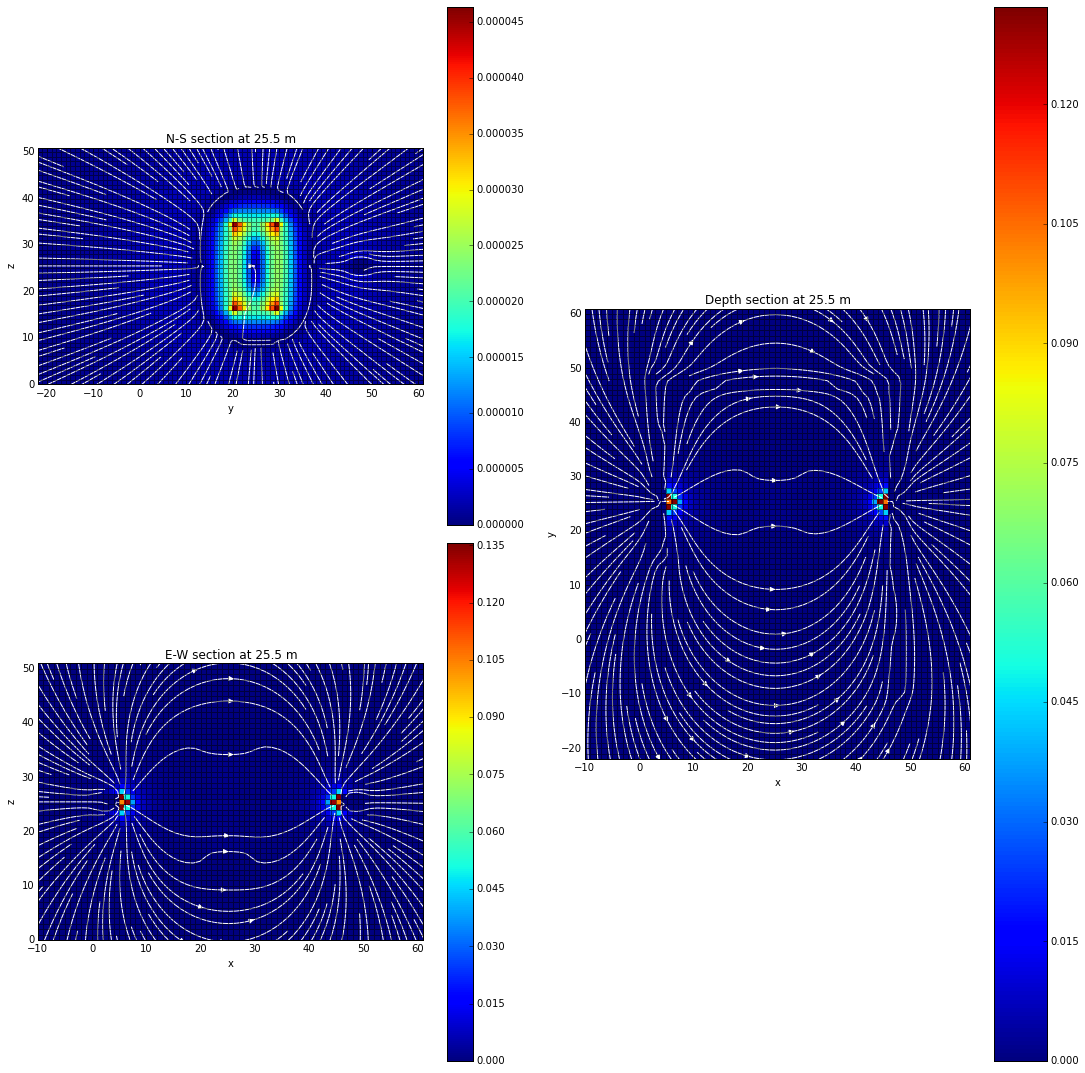

In [47]:
xSliceInd = 49
ySliceInd = 61
zSliceInd = 39
# xSliceInd = int(mesh.nCx/2)
# print xSliceInd
# ySliceInd = int(mesh.nCy/2)
# print ySliceInd
# zSliceInd = int(mesh.nCz/2)
# print zSliceInd


gs = gridspec.GridSpec(4, 4)

fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
ax1 = plt.subplot(gs[0:2, 0:2])
# ax = plt.subplot(3,1,1, aspect='equal')
out1 = mesh.plotSlice(mesh.aveF2CCV*j, ax =ax1, normal='X', vType='CCv', ind=xSliceInd, grid=True, view='vec', streamOpts={"density":10, "color":'w'})
ax1.set_title('N-S section at '+str(mesh.vectorCCx[xSliceInd])+' m')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([y0_core, y0_core + nCoreY])
plt.ylim([z0_core, z0_core + nCoreZ])
plt.colorbar(out1[0])

ax2 = plt.subplot(gs[2:4, 0:2])
# ax = plt.subplot(3,1,2, aspect='equal')
out2 = mesh.plotSlice(mesh.aveF2CCV*j, ax =ax2, normal='Y', vType='CCv', ind=ySliceInd, grid=True, view='vec', streamOpts={"density":10, "color":'w'})
ax2.set_title('E-W section at '+str(mesh.vectorCCy[ySliceInd])+' m')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([x0_core, x0_core + nCoreX])
plt.ylim([z0_core, z0_core + nCoreZ])
plt.colorbar(out2[0])

ax3 = plt.subplot(gs[0:4, 2:4])
# ax = plt.subplot(3,1,3, aspect='equal')
out3 = mesh.plotSlice(mesh.aveF2CCV*j, ax =ax3, normal='Z', vType='CCv', ind=zSliceInd, grid=True,view='vec', streamOpts={"density":10, "color":'w'})
ax3.set_title('Depth section at '+str(mesh.vectorCCz[zSliceInd])+' m')
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.xlim([x0_core, x0_core + nCoreX])
plt.ylim([y0_core, y0_core + nCoreY])
plt.colorbar(out3[0])


NameError: name 'u1' is not defined